<a href="https://colab.research.google.com/github/ccg-esb-lab/MDR_IS_Model/blob/main/MonodGillespieIS_conjugation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plasmid Dynamics Under Variable Conjugation Rates

This notebook simulates plasmid spread in a fully connected horizontal-transfer network, varying the
conjugation coefficient over several orders of magnitude. It identifies the transfer threshold separating
plasmid extinction from stable plasmid persistence in multispecies communities.


### Simulation Parameters


In [1]:

# Define parameters for each mutation-transposition level
num_mutationsSNP = 3  # Number of mutation levels
num_mutationsIS = 3  # Number of transposition levels

# Set initial resource, max time, and antibiotic concentration
initial_resource = 1.0
simulation_time = 24.0
B0=1e6

# Shared parameters
num_days = 45
dilution_factor = 0.1  # dilution factor applied each day

num_reps = 5
days=range(0, num_days + 1)

strainIDs = ["K253", "K168", "K037", "K241", "K209"]  # Species IDs
species_colors=['orange','blue',  'purple', 'green', 'yellow']

In [2]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sys
import pickle
import importlib.util

## GitHub repository

In [3]:
repo_url = "https://github.com/jorgEVOplasmids/MDR_ISs.git"
repo_name = "MDR_ISs"

if not Path(repo_name).exists():
  !git clone {repo_url}

REPO_ROOT = Path(repo_name).resolve()

In [4]:
# Repository paths
pathCODE    = REPO_ROOT / "Computational_model/code"
pathPARAMS  = REPO_ROOT / "Computational_model/data"
pathFIGURES = REPO_ROOT / "Computational_model/figures"
pathSIM     = REPO_ROOT / f"Computational_model/runs"

print("pathCODE:", pathCODE)
print("pathPARAMS:", pathPARAMS)
print("pathFIGURES:", pathFIGURES)
print("pathSIM:", pathSIM)

# Ensure output directories exist
pathFIGURES.mkdir(parents=True, exist_ok=True)
pathSIM.mkdir(parents=True, exist_ok=True)


pathCODE: /content/MDR_IS_Model/code
pathPARAMS: /content/MDR_IS_Model/data
pathFIGURES: /content/MDR_IS_Model/figures
pathSIM: /content/MDR_IS_Model/runs


In [5]:

sys.path.append(str(pathCODE))
import MonodGillespieIS_multispecies as mg
print("Module loaded successfully!")

Module loaded successfully!


## Evolutionary model


### Load params

In [6]:

mg.num_species = len(strainIDs)  # Number of species
strains_species = mg.load_strain_parameters(strainIDs, pathPARAMS)
num_species = len(strainIDs)

Plasmid-free parameters for strain K253 loaded successfully from:
/content/MDR_IS_Model/data/params_K253_0.pkl

Plasmid-bearing parameters for strain K253 loaded successfully from:
/content/MDR_IS_Model/data/params_K253_p.pkl

Plasmid-free parameters for strain K168 loaded successfully from:
/content/MDR_IS_Model/data/params_K168_0.pkl

Plasmid-bearing parameters for strain K168 loaded successfully from:
/content/MDR_IS_Model/data/params_K168_p.pkl

Plasmid-free parameters for strain K037 loaded successfully from:
/content/MDR_IS_Model/data/params_K037_0.pkl

Plasmid-bearing parameters for strain K037 loaded successfully from:
/content/MDR_IS_Model/data/params_K037_p.pkl

Plasmid-free parameters for strain K241 loaded successfully from:
/content/MDR_IS_Model/data/params_K241_0.pkl

Plasmid-bearing parameters for strain K241 loaded successfully from:
/content/MDR_IS_Model/data/params_K241_p.pkl

Plasmid-free parameters for strain K209 loaded successfully from:
/content/MDR_IS_Model/data

### Define initial conditions

In [7]:

initial_values_by_strain = {
    "K253": {"0": 1e6, "p": 0},     # Initial densities
    "K168": {"0": 1e6, "p": 0},     # Initial densities
    "K037": {"0": 1e6, "p": 0},      # Initial densities
     "K241": {"0": 1e6, "p": 100},      # Initial densities
     "K209": {"0": 1e6, "p": 0},      # Initial densities
}

# Define initial conditions
populations_0, populations_p = mg.initialize_populations(
    num_species=num_species,
    num_mutationsSNP=num_mutationsSNP,
    num_mutationsIS=num_mutationsIS,
    strainIDs=strainIDs,
    initial_values_by_strain=initial_values_by_strain
)


### Run simulation

In [8]:

antibiotic_concentration=0.2
eps_values = np.logspace(-11, -7, num=11)

expe_results = []  # Will store list of dicts per eps value

for eps in eps_values:
    print("Conjugation_rate=",eps)


    eps_str = f"{eps:.2e}"  # Format eps nicely
    filename = f"expe_result_eps_{eps_str}.pkl"
    filepath = os.path.join(pathSIM, filename)

    if os.path.exists(filepath):
        print(f"Loading existing simulation for eps = {eps_str}")
        with open(filepath, 'rb') as f:
            expe_results_dict = pickle.load(f)

    else:

      # Define the plasmid transmission matrix
      plasmid_matrix = np.array([
          [eps, eps, eps, eps, eps],  # K253
          [eps, eps, eps, eps, eps],  # K168
          [eps, eps, eps, eps, eps],   # K037
          [eps, eps, eps, eps, eps],   # K241
          [eps, eps, eps, eps, eps],   # K209
      ])

      #Run simulation
      results = mg.runManySimulations(
          plasmid_matrix=plasmid_matrix,
          num_reps=num_reps,
          runSimulationIS_multi_species=mg.runSimulationIS_multi_species,
          strains=strains_species,
          initial_populations_0=populations_0,
          initial_populations_p=populations_p,
          num_days=num_days,
          antibiotic_concentration=antibiotic_concentration,
          initial_resource=initial_resource,
          simulation_time=simulation_time,
          dilution_factor=dilution_factor
      )

      #Compute and store statistics
      diversity_metrics = mg.computeStrainDiversity(results)
      stats = mg.computeMutationAndISTranspositionStatistics(results, num_mutationsSNP, num_mutationsIS, num_species)
      cumulative_densities_free, cumulative_densities_bearing = mg.computeCumulativeStrainDensities(results, num_species, num_days)
      plasmid_fraction_stats = mg.computePlasmidFraction(results)
      expe_results_dict = {
          "eps": eps,
          "strain_densities": {},
          "plasmid_fraction": plasmid_fraction_stats.get("Plasmid Fraction", np.nan),
          "plasmid_free_density": plasmid_fraction_stats.get("Plasmid-Free Density", np.nan),
          "plasmid_bearing_density": plasmid_fraction_stats.get("Plasmid-Bearing Density", np.nan),
          "IS_Cumulative_Frequency": stats.get("IS_Cumulative_Frequency", np.nan),
          "SNP_Cumulative_Frequency": stats.get("SNP_Cumulative_Frequency", np.nan),
      }
      #Save final densities of each strain
      for species_idx in range(num_species):
              free_density = cumulative_densities_free[species_idx, -1]
              bearing_density = cumulative_densities_bearing[species_idx, -1]
              strain_label = strainIDs[species_idx]
              expe_results_dict["strain_densities"][strain_label] = {
                  "free": free_density,
                  "bearing": bearing_density
      }

      with open(filepath, 'wb') as f:
          pickle.dump(expe_results_dict, f)

    expe_results.append(expe_results_dict)

    # Run print functions
    mg.printCumulativeStrainDensities(cumulative_densities_free, cumulative_densities_bearing, num_species, strainIDs)
    mg.printPlasmidFraction(plasmid_fraction_stats)
    mg.printStrainDiversity(diversity_metrics)
    mg.printMutationAndISTranspositionStatistics(stats)

    # Plot results
    #expe_path='' #If empty, dont save figures
    #mg.plotResults(plasmid_matrix, populations_0, populations_p, expe_results_dict, num_mutationsSNP, num_mutationsIS, num_days, num_species, species_colors, strainIDs, pathFIGURES, expe_path, antibiotic_concentration)


Conjugation_rate= 1e-11
.....
=== Final Cumulative Strain Densities ===

Species           Plasmid-Free     Plasmid-Bearing               Total
----------------------------------------------------------------------
K253                  3.78e+03            0.00e+00            3.78e+03
K168 *                2.83e+08            0.00e+00            2.83e+08
K037                  2.97e+02            0.00e+00            2.97e+02
K241                  4.07e+02            0.00e+00            4.07e+02
K209                  6.14e+04            0.00e+00            6.14e+04

=== Final Plasmid Fraction Summary ===

Category                 Density
---------------------------------------------
Plasmid-Free Cells       2.83e+08
Plasmid-Bearing Cells    0.00e+00
Total Cells              2.83e+08
Plasmid Fraction         0.0000

=== Strain Diversity Metrics ===

Metric              Value
-----------------------------------
Shannon Entropy     0.0032
Simpson Index       0.0005
Total Surviving Strains5


Saved plot to /content/MDR_IS_Model/figureseps_vs_fraction.pdf


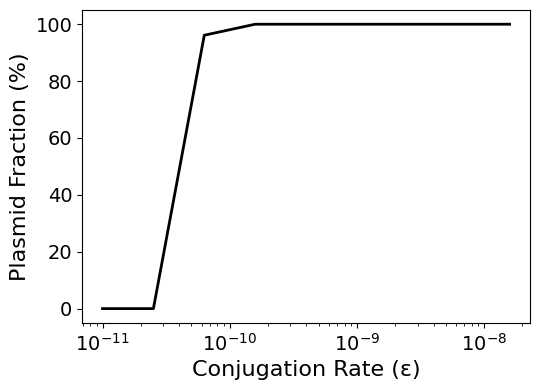

In [9]:
def plot_eps_vs_plasmid_fraction(expe_results, outPath=''):
    """
    Plots conjugation rate (eps) vs plasmid fraction (%).

    Parameters:
    expe_results (list of dicts): Output from simulations, each dict must contain 'eps' and 'plasmid_fraction'.
    outPath (str): Path to save the figure (optional).

    Returns:
    None
    """
    eps_values = [entry["eps"] for entry in expe_results]

    # Ensure we extract a single value (mean) if it's a list or array
    plasmid_fractions = []
    for entry in expe_results:
        val = entry["plasmid_fraction"]
        if isinstance(val, (list, np.ndarray)):
            plasmid_fractions.append(np.mean(val))
        else:
            plasmid_fractions.append(val)

    fig, ax = plt.subplots(figsize=(5.5, 4))

    ax.plot(eps_values, 100 * np.array(plasmid_fractions), lw=2, linestyle='-', color='black')
    ax.set_xscale("log")
    ax.set_ylim([-5, 105])
    ax.set_xlabel("Conjugation Rate (ε)", fontsize=16)
    ax.set_ylabel("Plasmid Fraction (%)", fontsize=16)
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=14)
    plt.tight_layout()

    if outPath:
        filename = f"{outPath}eps_vs_fraction.pdf"
        plt.savefig(filename)
        print(f"Saved plot to {filename}")
        plt.show()
    else:
        plt.show()

plot_eps_vs_plasmid_fraction(expe_results[:-2], outPath=pathFIGURES)


Saved plot to /content/MDR_IS_Model/figureseps_vs_frequencies.pdf


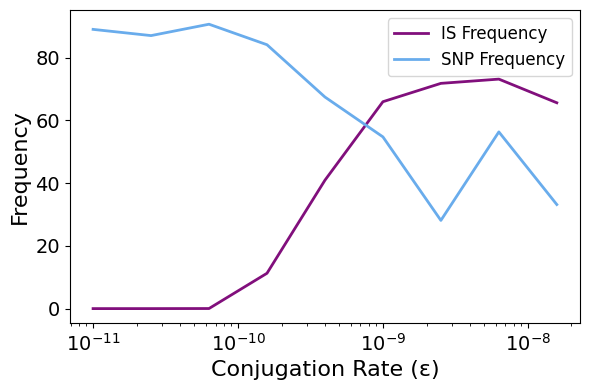

In [10]:
def plot_eps_vs_frequencies(expe_results, outPath=''):
    """
    Plots ε vs IS and SNP cumulative frequencies.
    """
    eps_values = [e["eps"] for e in expe_results]
    IS_freq  = [e["IS_Cumulative_Frequency"]  for e in expe_results]
    SNP_freq = [e["SNP_Cumulative_Frequency"] for e in expe_results]

    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(eps_values, IS_freq,  color='#810F7C',   lw=2, label='IS Frequency')
    ax.plot(eps_values, SNP_freq, color='#69acecff', lw=2, label='SNP Frequency')

    ax.set_xscale("log")
    ax.set_xlabel("Conjugation Rate (ε)", fontsize=16)
    ax.set_ylabel("Frequency", fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(False)
    ax.legend(fontsize=12)

    plt.tight_layout()

    if outPath:
        filename = f"{outPath}eps_vs_frequencies.pdf"
        plt.savefig(filename)
        print(f"Saved plot to {filename}")

    plt.show()


plot_eps_vs_frequencies(expe_results[:-2], outPath=pathFIGURES)

In [11]:
def plot_strain_densities_vs_eps(expe_results, strainIDs, species_colors, outPath=''):
    """
    Plots plasmid-free (dotted) and plasmid-bearing (solid) final densities
    for each strain as a function of the conjugation rate ε.
    """
    eps_values = [entry["eps"] for entry in expe_results]

    # Collect densities per strain
    free_densities = {s: [] for s in strainIDs}
    bearing_densities = {s: [] for s in strainIDs}

    for entry in expe_results:
        sd = entry["strain_densities"]
        for s in strainIDs:
            free_densities[s].append(sd[s]["free"])
            bearing_densities[s].append(sd[s]["bearing"])

    fig, ax = plt.subplots(figsize=(7, 4.5))

    for i, strain in enumerate(strainIDs):
        color = species_colors[i]
        ax.plot(eps_values, bearing_densities[strain], color=color, lw=2)
        ax.plot(eps_values, free_densities[strain],   color=color, lw=2, linestyle='dotted')

    ax.set_xscale("log")
    ax.set_xlabel("Conjugation Rate (ε)", fontsize=16)
    ax.set_ylabel("Final Density", fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(False)

    # Legend entries: one color square per strain
    handles = [
        plt.Rectangle((0, 0), 1, 1, facecolor=species_colors[i], edgecolor='black')
        for i in range(len(strainIDs))
    ]
    ax.legend(
        handles, strainIDs,
        fontsize=12,
        loc='upper left',
        bbox_to_anchor=(1.05, 1),
        title="Strains"
    )

    plt.tight_layout()

    if outPath:
        filename = f"{outPath}eps_vs_strains.pdf"
        plt.savefig(filename, bbox_inches='tight')
        print(f"Saved plot to {filename}")

    plt.show()
